In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Helper Functions

The following cells contain functions used throughout the course of the question, they include model class creation, Glorot Initialization, Standardization of inputs and a function for creating data loaders for use during Pytorch training

In [2]:
#Initializes using Glorot Initialization
def GlorotInitialize(model):
    #Initialize parameters
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices

In [3]:
def restructure_data(data):
    samples, vocab_size, max_word_count = np.max(data,axis=0)
    restructured_data = np.zeros((int(samples),int(vocab_size)))
    for i in range(len(data)):
        if (data[i,1]-1)<=vocab_size:
            restructured_data[int(data[i,0]-1),int(data[i,1]-1)]=data[i,2]
    return restructured_data

def tfidf(data):
    idf =  np.log(np.divide((data.shape[0]*np.ones_like(data)),1+np.sum(np.equal(data>0,1),axis=0)[None,:].astype(np.float)))
    return np.multiply(data,idf)

def make_loaders(data,labels,val_split,test_data=None,test_labels=None,batch_size=128):
    val_loader = 0
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    split = int((1-val_split)*indices.shape[0])
    train_data, val_data = data[indices[:split],:], data[indices[split:],:]
    train_labels, val_labels = labels[indices[:split]], labels[indices[split:]]
    del indices
    print train_data.shape, train_labels.shape
    print val_data.shape, val_labels.shape
    
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data),torch.IntTensor(train_labels))
    del train_data
    del train_labels
    train_loader = torch.utils.data.DataLoader(train_tensor,batch_size=batch_size, shuffle = True)
    del train_tensor
    if val_split<1:
        val_tensor = torch.utils.data.TensorDataset(torch.Tensor(val_data), torch.IntTensor(val_labels))
        del val_data
        del val_labels
        val_loader = torch.utils.data.DataLoader(val_tensor,batch_size=batch_size, shuffle = True)
        del val_tensor
        
    if (type(test_data) != type(None)):
        test_tensor = torch.utils.data.TensorDataset(torch.Tensor(test_data),torch.IntTensor(test_labels))
        test_loader = torch.utils.data.DataLoader(test_tensor,batch_size=batch_size, shuffle = True)
        return train_loader, val_loader, test_loader

    return train_loader, val_loader


def standardize_data(data):
    #standardized_data = np.divide(data - np.mean(data,axis=0)[None,:],np.var(data,axis=0)+1e-5)
    s = StandardScaler()
    s.fit(data)
    s.var_ += 1e-5
    standardized_data = s.transform(data)
    return standardized_data

In [4]:
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None, verbose=True):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        elif (verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)

In [5]:
def train_5000(model,train_loader,optimizer,loss_func, verbose= True):
    losses = [0]*5000
    batch_number = 0
    model = GlorotInitialize(model)
    for i in range(1000):
        for batch_index, (inputs, targets) in enumerate(train_loader):
            
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            loss = loss_func(logits,targets)
            
            loss.backward()
            optimizer.step()
            losses[batch_number] = (loss.data[0])
            if (verbose or batch_number%500==0):
                print "Iteration: " + repr(batch_number + 1) + " Loss: " + repr(loss.data[0])
            batch_number += 1
            if batch_number == 5000:
                plt.plot(losses, label='Train losses')
                plt.legend()
                plt.show()
                return model,losses

In [6]:
VocabSize = 51000
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

### 2.A Building the Model

Here we will test different preprocessing methods on the data set. First we'll explore basic word counts, then tf-idf preprocessing and finally standardization of inputs

#### 2.A No preprocessing

In [7]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

count_train = countVect.transform(newsgroups_train.data)
count_test = countVect.transform(newsgroups_test.data)

count_train = count_train.todense()
count_test = count_test.todense()

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [8]:
train_loader_ng_count,val_loader_ng_count, test_loader_ng_count = make_loaders(count_train,train_labels,
                                                                         0.2,count_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for no preprocessing

Learning rate: 0.001
Epoch : 1 Loss : 2.428  Train Accuracy: 0.374 Validation Accuracy: 0.465 Test Accuracy: 0.389
Epoch : 2 Loss : 27.212  Train Accuracy: 0.360 Validation Accuracy: 0.393 Test Accuracy: 0.345
Epoch : 3 Loss : 9.923  Train Accuracy: 0.373 Validation Accuracy: 0.318 Test Accuracy: 0.265
Epoch : 4 Loss : 6.404  Train Accuracy: 0.239 Validation Accuracy: 0.194 Test Accuracy: 0.176
Epoch : 5 Loss : 6.947  Train Accuracy: 0.184 Validation Accuracy: 0.133 Test Accuracy: 0.112
Epoch : 6 Loss : 6.521  Train Accuracy: 0.166 Validation Accuracy: 0.140 Test Accuracy: 0.119
Epoch : 7 Loss : 9.204  Train Accuracy: 0.143 Validation Accuracy: 0.133 Test Accuracy: 0.105
Epoch : 8 Loss : 6.754  Train Accuracy: 0.145 Validation Accuracy: 0.129 Test Accuracy: 0.114
Epoch : 9 Loss : 29.386  Train Accuracy: 0.156 Validation Accuracy: 0.130 Test Accuracy: 0.108
Epoch : 10 Loss : 14.910  Train Accuracy: 0.144 Validation Accuracy: 0.129 Test Accuracy: 0.104
Epoch : 11 Loss : 26.568  Train Acc

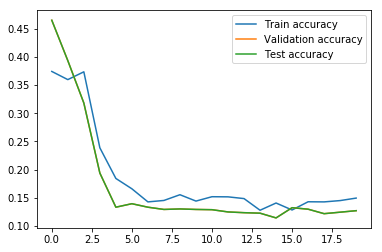

Learning rate: 0.0001
Epoch : 1 Loss : 2.902  Train Accuracy: 0.223 Validation Accuracy: 0.468 Test Accuracy: 0.435
Epoch : 2 Loss : 2.015  Train Accuracy: 0.639 Validation Accuracy: 0.698 Test Accuracy: 0.604
Epoch : 3 Loss : 1.120  Train Accuracy: 0.749 Validation Accuracy: 0.691 Test Accuracy: 0.613
Epoch : 4 Loss : 1.131  Train Accuracy: 0.717 Validation Accuracy: 0.617 Test Accuracy: 0.532
Epoch : 5 Loss : 3.324  Train Accuracy: 0.660 Validation Accuracy: 0.584 Test Accuracy: 0.540
Epoch : 6 Loss : 3.328  Train Accuracy: 0.639 Validation Accuracy: 0.563 Test Accuracy: 0.482
Epoch : 7 Loss : 2.208  Train Accuracy: 0.574 Validation Accuracy: 0.442 Test Accuracy: 0.396
Epoch : 8 Loss : 1.922  Train Accuracy: 0.480 Validation Accuracy: 0.444 Test Accuracy: 0.374
Epoch : 9 Loss : 1.562  Train Accuracy: 0.516 Validation Accuracy: 0.485 Test Accuracy: 0.410
Epoch : 10 Loss : 1.418  Train Accuracy: 0.623 Validation Accuracy: 0.604 Test Accuracy: 0.511
Epoch : 11 Loss : 1.329  Train Accura

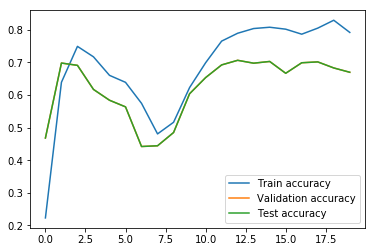

Learning rate: 1e-05
Epoch : 1 Loss : 3.008  Train Accuracy: 0.059 Validation Accuracy: 0.097 Test Accuracy: 0.097
Epoch : 2 Loss : 2.882  Train Accuracy: 0.248 Validation Accuracy: 0.343 Test Accuracy: 0.307
Epoch : 3 Loss : 2.664  Train Accuracy: 0.468 Validation Accuracy: 0.481 Test Accuracy: 0.429
Epoch : 4 Loss : 2.318  Train Accuracy: 0.581 Validation Accuracy: 0.584 Test Accuracy: 0.516
Epoch : 5 Loss : 1.921  Train Accuracy: 0.681 Validation Accuracy: 0.704 Test Accuracy: 0.611
Epoch : 6 Loss : 1.550  Train Accuracy: 0.751 Validation Accuracy: 0.735 Test Accuracy: 0.646
Epoch : 7 Loss : 1.238  Train Accuracy: 0.780 Validation Accuracy: 0.732 Test Accuracy: 0.639
Epoch : 8 Loss : 0.994  Train Accuracy: 0.791 Validation Accuracy: 0.772 Test Accuracy: 0.683
Epoch : 9 Loss : 0.793  Train Accuracy: 0.828 Validation Accuracy: 0.782 Test Accuracy: 0.693
Epoch : 10 Loss : 0.685  Train Accuracy: 0.823 Validation Accuracy: 0.790 Test Accuracy: 0.702
Epoch : 11 Loss : 0.594  Train Accurac

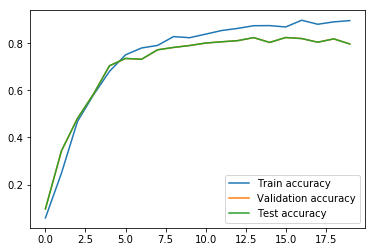

Learning rate: 1e-06
Epoch : 1 Loss : 3.005  Train Accuracy: 0.059 Validation Accuracy: 0.062 Test Accuracy: 0.057
Epoch : 2 Loss : 2.981  Train Accuracy: 0.074 Validation Accuracy: 0.077 Test Accuracy: 0.075
Epoch : 3 Loss : 2.951  Train Accuracy: 0.113 Validation Accuracy: 0.128 Test Accuracy: 0.116
Epoch : 4 Loss : 2.909  Train Accuracy: 0.194 Validation Accuracy: 0.207 Test Accuracy: 0.187
Epoch : 5 Loss : 2.858  Train Accuracy: 0.294 Validation Accuracy: 0.306 Test Accuracy: 0.268
Epoch : 6 Loss : 2.794  Train Accuracy: 0.382 Validation Accuracy: 0.383 Test Accuracy: 0.340
Epoch : 7 Loss : 2.713  Train Accuracy: 0.463 Validation Accuracy: 0.452 Test Accuracy: 0.397
Epoch : 8 Loss : 2.618  Train Accuracy: 0.522 Validation Accuracy: 0.493 Test Accuracy: 0.445
Epoch : 9 Loss : 2.506  Train Accuracy: 0.568 Validation Accuracy: 0.541 Test Accuracy: 0.484
Epoch : 10 Loss : 2.384  Train Accuracy: 0.600 Validation Accuracy: 0.572 Test Accuracy: 0.508
Epoch : 11 Loss : 2.256  Train Accurac

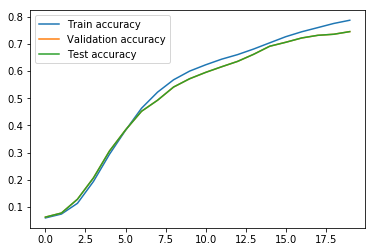

In [9]:
lrs = [1e-3,1e-4,1e-5,1e-6]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_count,optimizer,val_loader_ng_count,
                             test_loader_ng_count)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be 1e-05

#### 2.A TF-IDF Preprocessing

In [7]:
tfidfVect = TfidfVectorizer(max_features=VocabSize,stop_words='english')
tfidfVect.fit(newsgroups_train.data)

tfidf_train = tfidfVect.transform(newsgroups_train.data)
tfidf_test = tfidfVect.transform(newsgroups_test.data)


tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()
train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [8]:
train_loader_ng_tfidf,val_loader_ng_tfidf, test_loader_ng_tfidf = make_loaders(tfidf_train,train_labels,
                                                                         0.2,tfidf_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for TFIDF preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 2.969  Train Accuracy: 0.076 Validation Accuracy: 0.083 Test Accuracy: 0.065
Epoch : 2 Loss : 3.399  Train Accuracy: 0.133 Validation Accuracy: 0.056 Test Accuracy: 0.051
Epoch : 3 Loss : 8.218  Train Accuracy: 0.068 Validation Accuracy: 0.048 Test Accuracy: 0.052
Epoch : 4 Loss : 9.323  Train Accuracy: 0.058 Validation Accuracy: 0.054 Test Accuracy: 0.053
Epoch : 5 Loss : 17.133  Train Accuracy: 0.055 Validation Accuracy: 0.053 Test Accuracy: 0.050
Epoch : 6 Loss : 20.963  Train Accuracy: 0.049 Validation Accuracy: 0.058 Test Accuracy: 0.053
Epoch : 7 Loss : 29.061  Train Accuracy: 0.057 Validation Accuracy: 0.053 Test Accuracy: 0.053
Epoch : 8 Loss : 53.416  Train Accuracy: 0.053 Validation Accuracy: 0.056 Test Accuracy: 0.053
Epoch : 9 Loss : 75.692  Train Accuracy: 0.045 Validation Accuracy: 0.047 Test Accuracy: 0.052
Epoch : 10 Loss : 99.156  Train Accuracy: 0.053 Validation Accuracy: 0.051 Test Accuracy: 0.051
Epoch : 11 Loss : 108.936  Train 

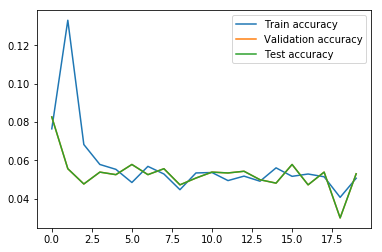

Learning rate: 0.001
Epoch : 1 Loss : 2.991  Train Accuracy: 0.086 Validation Accuracy: 0.141 Test Accuracy: 0.133
Epoch : 2 Loss : 2.951  Train Accuracy: 0.109 Validation Accuracy: 0.247 Test Accuracy: 0.217
Epoch : 3 Loss : 2.834  Train Accuracy: 0.329 Validation Accuracy: 0.403 Test Accuracy: 0.354
Epoch : 4 Loss : 2.585  Train Accuracy: 0.306 Validation Accuracy: 0.289 Test Accuracy: 0.248
Epoch : 5 Loss : 2.334  Train Accuracy: 0.311 Validation Accuracy: 0.401 Test Accuracy: 0.363
Epoch : 6 Loss : 2.290  Train Accuracy: 0.362 Validation Accuracy: 0.381 Test Accuracy: 0.330
Epoch : 7 Loss : 3.802  Train Accuracy: 0.290 Validation Accuracy: 0.202 Test Accuracy: 0.174
Epoch : 8 Loss : 9.706  Train Accuracy: 0.153 Validation Accuracy: 0.053 Test Accuracy: 0.053
Epoch : 9 Loss : 11.758  Train Accuracy: 0.078 Validation Accuracy: 0.062 Test Accuracy: 0.053
Epoch : 10 Loss : 5.449  Train Accuracy: 0.069 Validation Accuracy: 0.052 Test Accuracy: 0.054
Epoch : 11 Loss : 5.279  Train Accura

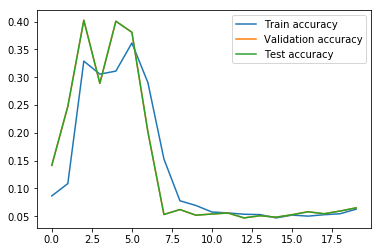

Learning rate: 0.0001
Epoch : 1 Loss : 2.995  Train Accuracy: 0.054 Validation Accuracy: 0.067 Test Accuracy: 0.067
Epoch : 2 Loss : 2.990  Train Accuracy: 0.073 Validation Accuracy: 0.068 Test Accuracy: 0.067
Epoch : 3 Loss : 2.981  Train Accuracy: 0.085 Validation Accuracy: 0.088 Test Accuracy: 0.080
Epoch : 4 Loss : 2.969  Train Accuracy: 0.094 Validation Accuracy: 0.086 Test Accuracy: 0.070
Epoch : 5 Loss : 2.951  Train Accuracy: 0.151 Validation Accuracy: 0.214 Test Accuracy: 0.189
Epoch : 6 Loss : 2.926  Train Accuracy: 0.331 Validation Accuracy: 0.299 Test Accuracy: 0.243
Epoch : 7 Loss : 2.889  Train Accuracy: 0.386 Validation Accuracy: 0.447 Test Accuracy: 0.390
Epoch : 8 Loss : 2.840  Train Accuracy: 0.622 Validation Accuracy: 0.646 Test Accuracy: 0.583
Epoch : 9 Loss : 2.775  Train Accuracy: 0.696 Validation Accuracy: 0.591 Test Accuracy: 0.525
Epoch : 10 Loss : 2.685  Train Accuracy: 0.621 Validation Accuracy: 0.583 Test Accuracy: 0.533
Epoch : 11 Loss : 2.554  Train Accura

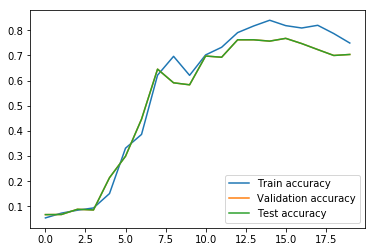

Learning rate: 1e-05
Epoch : 1 Loss : 2.996  Train Accuracy: 0.056 Validation Accuracy: 0.060 Test Accuracy: 0.055
Epoch : 2 Loss : 2.995  Train Accuracy: 0.062 Validation Accuracy: 0.065 Test Accuracy: 0.061
Epoch : 3 Loss : 2.994  Train Accuracy: 0.069 Validation Accuracy: 0.076 Test Accuracy: 0.072
Epoch : 4 Loss : 2.992  Train Accuracy: 0.073 Validation Accuracy: 0.077 Test Accuracy: 0.075
Epoch : 5 Loss : 2.990  Train Accuracy: 0.077 Validation Accuracy: 0.081 Test Accuracy: 0.077
Epoch : 6 Loss : 2.987  Train Accuracy: 0.080 Validation Accuracy: 0.085 Test Accuracy: 0.079
Epoch : 7 Loss : 2.984  Train Accuracy: 0.090 Validation Accuracy: 0.099 Test Accuracy: 0.097
Epoch : 8 Loss : 2.980  Train Accuracy: 0.113 Validation Accuracy: 0.112 Test Accuracy: 0.111
Epoch : 9 Loss : 2.976  Train Accuracy: 0.128 Validation Accuracy: 0.117 Test Accuracy: 0.118
Epoch : 10 Loss : 2.972  Train Accuracy: 0.135 Validation Accuracy: 0.129 Test Accuracy: 0.126
Epoch : 11 Loss : 2.968  Train Accurac

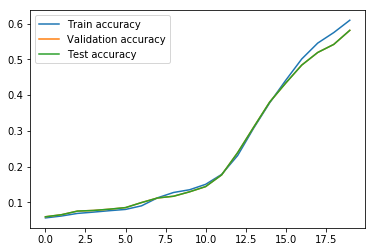

In [9]:
lrs = [1e-2,1e-3,1e-4,1e-5]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_tfidf,optimizer,val_loader_ng_tfidf, test_loader_ng_tfidf)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be ####

#### 2.A Standardization of input features

In [7]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

stand_train = countVect.transform(newsgroups_train.data)
stand_test = countVect.transform(newsgroups_test.data)

stand_train = stand_train.todense()
stand_test = stand_test.todense()

stand_train = standardize_data(stand_train)
stand_test = standardize_data(stand_test)

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

/home/kyle/Downloads/yes/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
print stand_train.s

In [9]:
train_loader_ng_stand, val_loader_ng_stand, test_loader_ng_stand = make_loaders(stand_train,train_labels,0.2,stand_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for Standardized features preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 8930.694  Train Accuracy: 0.449 Validation Accuracy: 0.474 Test Accuracy: 0.430
Epoch : 2 Loss : 2023670292.606  Train Accuracy: 0.543 Validation Accuracy: 0.518 Test Accuracy: 0.448
Epoch : 3 Loss : 1436060852964395.250  Train Accuracy: 0.524 Validation Accuracy: 0.395 Test Accuracy: 0.386
Epoch : 4 Loss : 485438820791276797952.000  Train Accuracy: 0.559 Validation Accuracy: 0.553 Test Accuracy: 0.499
Epoch : 5 Loss : 219420545769565980897312768.000  Train Accuracy: 0.563 Validation Accuracy: 0.531 Test Accuracy: 0.476
Epoch : 6 Loss : 128064596401441049526393576095744.000  Train Accuracy: 0.541 Validation Accuracy: 0.529 Test Accuracy: 0.471
Epoch : 7 Loss : nan  Train Accuracy: 0.343 Validation Accuracy: 0.043 Test Accuracy: 0.042
Epoch : 8 Loss : nan  Train Accuracy: 0.042 Validation Accuracy: 0.043 Test Accuracy: 0.042
Epoch : 9 Loss : nan  Train Accuracy: 0.042 Validation Accuracy: 0.043 Test Accuracy: 0.042
Epoch : 10 Loss : nan  Train Accura

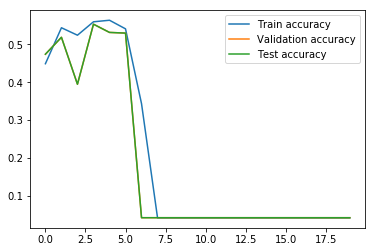

Learning rate: 0.001
Epoch : 1 Loss : 2.584  Train Accuracy: 0.584 Validation Accuracy: 0.642 Test Accuracy: 0.545
Epoch : 2 Loss : 42.893  Train Accuracy: 0.754 Validation Accuracy: 0.645 Test Accuracy: 0.537
Epoch : 3 Loss : 943.950  Train Accuracy: 0.841 Validation Accuracy: 0.696 Test Accuracy: 0.555
Epoch : 4 Loss : 17864.865  Train Accuracy: 0.815 Validation Accuracy: 0.663 Test Accuracy: 0.580
Epoch : 5 Loss : 473491.340  Train Accuracy: 0.757 Validation Accuracy: 0.720 Test Accuracy: 0.591
Epoch : 6 Loss : 5271720.330  Train Accuracy: 0.838 Validation Accuracy: 0.700 Test Accuracy: 0.591
Epoch : 7 Loss : 137239913.775  Train Accuracy: 0.811 Validation Accuracy: 0.694 Test Accuracy: 0.548
Epoch : 8 Loss : 1822984865.352  Train Accuracy: 0.826 Validation Accuracy: 0.661 Test Accuracy: 0.526
Epoch : 9 Loss : 33198422692.056  Train Accuracy: 0.839 Validation Accuracy: 0.700 Test Accuracy: 0.551
Epoch : 10 Loss : 26013976536395.719  Train Accuracy: 0.664 Validation Accuracy: 0.597 T

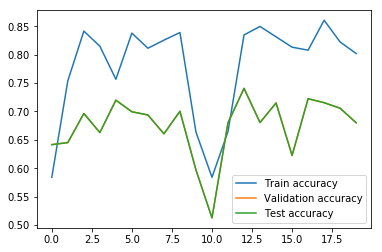

Learning rate: 0.0001
Epoch : 1 Loss : 2.247  Train Accuracy: 0.399 Validation Accuracy: 0.793 Test Accuracy: 0.674
Epoch : 2 Loss : 0.172  Train Accuracy: 0.963 Validation Accuracy: 0.838 Test Accuracy: 0.715
Epoch : 3 Loss : 0.103  Train Accuracy: 0.988 Validation Accuracy: 0.871 Test Accuracy: 0.758
Epoch : 4 Loss : 0.204  Train Accuracy: 0.986 Validation Accuracy: 0.866 Test Accuracy: 0.749
Epoch : 5 Loss : 0.496  Train Accuracy: 0.978 Validation Accuracy: 0.846 Test Accuracy: 0.730
Epoch : 6 Loss : 0.992  Train Accuracy: 0.973 Validation Accuracy: 0.875 Test Accuracy: 0.753
Epoch : 7 Loss : 0.711  Train Accuracy: 0.978 Validation Accuracy: 0.856 Test Accuracy: 0.728
Epoch : 8 Loss : 0.587  Train Accuracy: 0.992 Validation Accuracy: 0.861 Test Accuracy: 0.743
Epoch : 9 Loss : 0.989  Train Accuracy: 0.988 Validation Accuracy: 0.843 Test Accuracy: 0.728
Epoch : 10 Loss : 0.886  Train Accuracy: 0.991 Validation Accuracy: 0.858 Test Accuracy: 0.742
Epoch : 11 Loss : 0.722  Train Accura

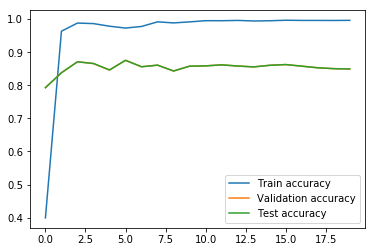

Learning rate: 1e-05
Epoch : 1 Loss : 3.343  Train Accuracy: 0.087 Validation Accuracy: 0.225 Test Accuracy: 0.184
Epoch : 2 Loss : 1.272  Train Accuracy: 0.735 Validation Accuracy: 0.714 Test Accuracy: 0.600
Epoch : 3 Loss : 0.355  Train Accuracy: 0.964 Validation Accuracy: 0.804 Test Accuracy: 0.693
Epoch : 4 Loss : 0.149  Train Accuracy: 0.971 Validation Accuracy: 0.813 Test Accuracy: 0.704
Epoch : 5 Loss : 0.096  Train Accuracy: 0.975 Validation Accuracy: 0.829 Test Accuracy: 0.710
Epoch : 6 Loss : 0.064  Train Accuracy: 0.984 Validation Accuracy: 0.840 Test Accuracy: 0.721
Epoch : 7 Loss : 0.036  Train Accuracy: 0.992 Validation Accuracy: 0.852 Test Accuracy: 0.730
Epoch : 8 Loss : 0.024  Train Accuracy: 0.994 Validation Accuracy: 0.863 Test Accuracy: 0.738
Epoch : 9 Loss : 0.022  Train Accuracy: 0.995 Validation Accuracy: 0.870 Test Accuracy: 0.741
Epoch : 10 Loss : 0.019  Train Accuracy: 0.996 Validation Accuracy: 0.875 Test Accuracy: 0.746
Epoch : 11 Loss : 0.014  Train Accurac

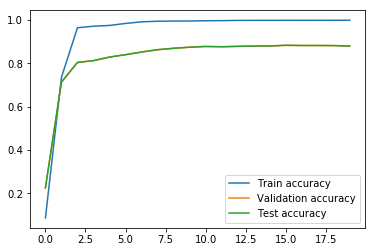

Learning rate: 1e-06
Epoch : 1 Loss : 3.576  Train Accuracy: 0.047 Validation Accuracy: 0.061 Test Accuracy: 0.059
Epoch : 2 Loss : 3.148  Train Accuracy: 0.099 Validation Accuracy: 0.108 Test Accuracy: 0.096
Epoch : 3 Loss : 2.460  Train Accuracy: 0.286 Validation Accuracy: 0.236 Test Accuracy: 0.193
Epoch : 4 Loss : 1.752  Train Accuracy: 0.580 Validation Accuracy: 0.429 Test Accuracy: 0.340
Epoch : 5 Loss : 1.172  Train Accuracy: 0.810 Validation Accuracy: 0.589 Test Accuracy: 0.483
Epoch : 6 Loss : 0.768  Train Accuracy: 0.917 Validation Accuracy: 0.692 Test Accuracy: 0.581
Epoch : 7 Loss : 0.507  Train Accuracy: 0.958 Validation Accuracy: 0.753 Test Accuracy: 0.645
Epoch : 8 Loss : 0.342  Train Accuracy: 0.973 Validation Accuracy: 0.785 Test Accuracy: 0.683
Epoch : 9 Loss : 0.236  Train Accuracy: 0.980 Validation Accuracy: 0.805 Test Accuracy: 0.710
Epoch : 10 Loss : 0.169  Train Accuracy: 0.985 Validation Accuracy: 0.822 Test Accuracy: 0.725
Epoch : 11 Loss : 0.125  Train Accurac

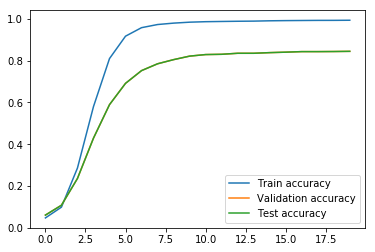

In [10]:
lrs = [1e-2,1e-3,1e-4,1e-5,1e-6]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_stand,optimizer,val_loader_ng_stand, test_loader_ng_stand)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

Optimal learning rate was found to be 

##### 2.A.1

Without preprocessing the model had an optimal learning rate of


##### 2.A.2.a
No the same learning rate could not be used for all of the models. It was found that without preprocessing training required substantially lower learning rates than for either tf-idf and standardization of features.

The same learning rate cannot be used for each model because 

##### 2.A.2.b

##### 2.A.2.c


### 2.B Variance in Training

##### tf-df Preprocessing with batch size 1

In [8]:
tfidfVect = TfidfVectorizer(max_features=VocabSize,stop_words='english')
tfidfVect.fit(newsgroups_train.data)

tfidf_train = tfidfVect.transform(newsgroups_train.data)


tfidf_train = tfidf_train.todense()
train_labels = newsgroups_train.target

In [9]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,train_labels,0.2,batch_size=1)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


Iteration: 1 Loss: 2.9865124225616455
Iteration: 501 Loss: 34.338645935058594
Iteration: 1001 Loss: 3.7401084899902344
Iteration: 1501 Loss: 50.700408935546875
Iteration: 2001 Loss: 48.84590148925781
Iteration: 2501 Loss: 239.5423583984375
Iteration: 3001 Loss: 105.76600646972656
Iteration: 3501 Loss: 95.14688110351562
Iteration: 4001 Loss: 0.06701701879501343
Iteration: 4501 Loss: 479.9583740234375


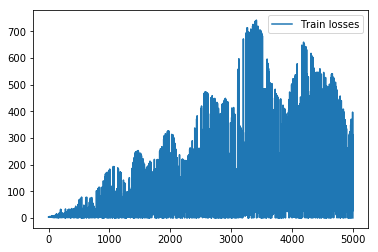

In [11]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func,verbose=False)

In [9]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,train_labels,0.2,batch_size=100)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


Iteration: 1 Loss: 2.995835065841675
Iteration: 501 Loss: 0.6259101033210754
Iteration: 1001 Loss: 0.8514846563339233
Iteration: 1501 Loss: 60.82896041870117
Iteration: 2001 Loss: 96.29426574707031
Iteration: 2501 Loss: 69.39492797851562
Iteration: 3001 Loss: 81.36959075927734
Iteration: 3501 Loss: 67.36750030517578
Iteration: 4001 Loss: 61.86973190307617
Iteration: 4501 Loss: 62.46577453613281


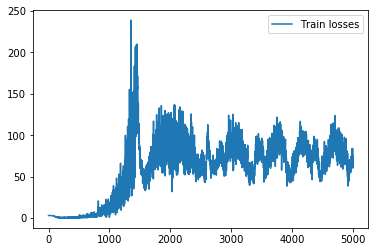

In [13]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func,verbose=False)

##### 2.B.1

Given that the two models are the same, there is much more variance in the loss per iteration when using a minibatch size of 1. The variance of the loss when training one example at a time is high, because the loss is calculated on the performance of a single point. When the network performs well on a single example, the loss for that example is quite low, whereas when it performs poorly on a single example, the loss is quite high. This leads to high variance in loss from iteration to iteration.  When considering the loss on a larger mini-batch size, in this case 100, the loss for an iteration is averaged across 100 samples. In any given set of 100 samples, the model will likely perform well on some, and poorly on others, but overall from batch to batch, one would expect the loss to approach the loss on the whole dataset as the size of the minibatch is increased.

##### 2.B.2

In order to reduce the variance of loss during training, when using a minibatch size of 1, one could reduce the learning rate when training using a small batchsize. Reducing the learning rate will decrease the size of the step taken for a single example.

In [ ]:
2.6%   |   3.00%  |  2.61%    |  2.7%     |  2.8%     |  2.75%  |

In [8]:
import numpy as np
a=[.026 ,.03 , .0261, .027, .028]
print np.std(a)

0.00147837748901
